## CpGs, Top 1000 Correlation with age    


### Summary

In this notebook we take in the PPMI Methylation data, process it to a dataframe named df_betas, and then select out of the 864,067 CpG columns those whose methylation beta values correlate most strongly with age. The correlations can be positive or negative. 

Then the following is done:
* PCA is performed on these 1000 CpGs and the first 10 PCs are saved.
* A PCA plot is presented PC1 and PC2
* A regression plot is presented with Age and PC1
* A linear regression model is run, regressing all 10 PCs and Age

### Results
* There is a very strong correlation between PC1 from these 1000 cpgs and age (-0.786)
* PC1 is sufficent to separate the data based on age
* A linear regression model of all 10 PCs on Age yields a R^2  of 0.849

### Comment
* I am worried here that this analysis is not useful due to the multiple testing problem. That is, here I select out of 867,067 CpGs the 1000 whose methylation probability correlates most with age. It could be that these correlations will not generalize, as they may arise randomly in such a large dataset 



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import pickle
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

### Files needed: 
The following files are needed for this notebook to run
* beta_post_Funnorm_PPMI_EPICn524final030618.csv  (Giant CpG datafile, 8 GB)
* Patient_Status.csv (Links PATNO with status, that is if healthy Control or not)
* PPMI_Meth_n524_for_LONI030718.txt (Links PATNO to Sentrix ID and Sentrix Position number)
* PPMI_Original_Cohort_BL_to_Year_5_Dataset_Apr2020.csv (Links PATNO and Age)

### Processing original data to a dataframe df_betas

### The code in the section below has been commented out because it needs a file too big for github

In [3]:
%%time
# Read data into a pandas dataframe (takes ~1 min)
df_original = pd.read_csv('../files/beta_post_Funnorm_PPMI_EPICn524final030618.csv')

CPU times: user 54.3 s, sys: 4.05 s, total: 58.4 s
Wall time: 58.4 s


In [6]:
df_original

,200973410159_R03C01,200991620021_R01C01,200991620021_R03C01,200989060105_R03C01,200989060135_R07C01,200989060162_R04C01,200973410167_R04C01,200973410143_R01C01,200973410143_R06C01,200973410167_R05C01,200973410167_R08C01,200989060001_R06C01,200989060130_R01C01,201004820204_R02C01,200973410121_R04C01,201004820204_R01C01,201004820204_R07C01,200989060051_R05C01,200973410159_R07C01,200989060143_R08C01,200989060061_R07C01,200973410144_R07C01,200989060002_R01C01,201004820064_R05C01,201004820067_R08C01,201050360014_R02C01,200989060162_R02C01,200989060162_R01C01,200973410159_R02C01,200991620021_R05C01,201050360065_R07C01,201050360065_R08C01,200989060105_R05C01,200989060135_R04C01,200989060135_R01C01,200989060135_R06C01,200989060152_R03C01,200989060152_R06C01,200989060140_R08C01,200989060018_R03C01,200989060088_R03C01,200989060130_R03C01,200989060140_R07C01,200989060104_R03C01,200989060149_R05C01,200989060076_R05C01,200989060076_R06C01,200989060019_R08C01,200989060051_R03C01,200989060063_R08C01,...,200991620029_R02C01,200989060128_R06C01,200991620011_R05C01,200989060063_R01C01,200973410144_R05C01,200989060051_R02C01,201050360013_R02C01,201004820182_R04C01,200989060059_R03C01,201004820182_R02C01,200989060002_R07C01,200989060002_R06C01,200989060059_R02C01,200989060002_R05C01,201050360013_R03C01,200989060002_R08C01,200989060002_R04C01,201004820064_R03C01,201004820064_R02C01,200989060016_R01C01,200989060155_R04C01,200989060016_R03C01,201004820067_R01C01,201050360080_R01C01,200989060015_R06C01,201004820067_R03C01,200989060015_R05C01,200989060155_R02C01,201004820067_R02C01,201004820064_R01C01,200989060016_R02C01,200989060155_R01C01,200989060155_R03C01,200989060111_R02C01,200989060089_R05C01,200989060089_R08C01,200973410143_R03C01,200989060089_R06C01,200973410143_R02C01,200989060089_R07C01,200989060089_R02C01,200989060089_R01C01,200989060089_R04C01,200973410143_R08C01,200973410143_R07C01,200989060089_R03C01,200989060150_R04C01,200989060150_R05C01,200989060150_R06C01,200991620049_R08C01
cg14817997,0.834027,0.849201,0.772995,0.885288,0.772547,0.756429,0.719766,0.775910,0.768914,0.759352,0.795625,0.891317,0.742504,0.867388,0.769844,0.770247,0.878363,0.841146,0.829701,0.821689,0.802980,0.798074,0.843244,0.808056,0.844132,0.864657,0.739420,0.834967,0.819567,0.860576,0.867707,0.773038,0.872103,0.839999,0.681789,0.797015,0.856449,0.871304,0.816523,0.884845,0.649361,0.899033,0.898411,0.824195,0.894209,0.839778,0.795766,0.800306,0.880423,0.872456,...,0.852141,0.833748,0.903717,0.849770,0.884695,0.856700,0.810066,0.855698,0.821039,0.837140,0.825906,0.828405,0.835968,0.767863,0.870102,0.879215,0.769560,0.768757,0.792708,0.857593,0.853505,0.880486,0.869945,0.749873,0.835692,0.847864,0.850901,0.878288,0.840729,0.853989,0.829916,0.640835,0.854405,0.865783,0.859396,0.676867,0.843813,0.846000,0.839355,0.845670,0.788239,0.838946,0.845263,0.770405,0.852917,0.783813,0.806930,0.875691,0.661276,0.737917
cg26928153,0.945589,0.948538,0.962199,0.944048,0.926306,0.956061,0.912988,0.955983,0.957120,0.897589,0.903653,0.955011,0.959265,0.946926,0.923453,0.950094,0.941681,0.962631,0.929738,0.962049,0.952244,0.946619,0.944037,0.922878,0.939210,0.944841,0.945367,0.955434,0.929189,0.964482,0.941702,0.948533,0.939698,0.946993,0.936361,0.928655,0.956873,0.959469,0.942242,0.948062,0.941974,0.968992,0.945380,0.947652,0.955692,0.959672,0.960464,0.947146,0.962020,0.950081,...,0.951714,0.957627,0.943639,0.952122,0.956411,0.952790,0.959647,0.941830,0.952177,0.952307,0.934586,0.950930,0.961342,0.943737,0.952345,0.946540,0.946362,0.934183,0.928783,0.942799,0.946971,0.942294,0.948537,0.963866,0.939205,0.938614,0.931799,0.939543,0.955561,0.946418,0.948509,0.929676,0.951027,0.942496,0.953410,0.952721,0.953248,0.951971,0.960411,0.946679,0.951206,0.958975,0.957062,0.954738,0.947765,0.958086,0.948044,0.942405,0.954990,0.946272
cg16269199,0.845186,0.911488,0.948206,0.913622,0.778551,0.903924,0.742258,0.934683,0.897787,0.741083,0.739018,0.873728,0.934866,0.919843,0.871728,0.937627,0.920651,0

In [7]:
# read in a file with patient numbers (PATNO) and statuses (heathy control of not)
df_patient = pd.read_csv('../files/Patient_Status.csv')

In [8]:
# Make new patient status dataframe with just Healthy Control patients
df_HC = df_patient[df_patient['RECRUITMENT_CAT'] == 'HC']

In [9]:
# Read in a file linking PATNOs to Sentrix numbers, these are numbers in the big CpG file 
# There are no PATNO numbers there, so they need to be matched up
df_PATNO_Sentrix = pd.read_csv('../files/PPMI_Meth_n524_for_LONI030718.txt', sep = "\t")

In [10]:
# Fix an error in the file
df_PATNO_Sentrix.iloc[374, 0] = '3794'

In [11]:
# Make two dictionaries, linking PATNO to Sentrix number and vice versa
dict_PATNO_to_Sentrix = {}
dict_Sentrix_to_PATNO = {} 
for index, row in df_PATNO_Sentrix.iterrows():
    dict_PATNO_to_Sentrix[row[0]] = str(row[1])+"_"+str(row[2])
    dict_Sentrix_to_PATNO[str(row[1])+"_"+str(row[2])] = row[0]

In [12]:
# Figure out which columns in df_original are from healthy controls 
cols_to_drop = []
cols_to_keep = [] 
for col in df_original.columns:
    if int(dict_Sentrix_to_PATNO[col]) in list(df_HC.PATNO):
        cols_to_keep.append(col)

In [13]:
# Creat a dataframe from the original df but with just the healthy control columns
df_beta_keep = df_original[cols_to_keep]

In [14]:
# Make a new dataframe that is the original df transposed (columns = CpG sites, rows = patient) 
# with just the healthy controls patients and with a column of PATNO numbers added
patnos = []
for col in df_beta_keep.columns:
    patnos.append(dict_Sentrix_to_PATNO[col]) # mapping Sentrix number to PATNOs
df_betas = df_beta_keep.copy()
df_betas.columns = patnos
df_betas = df_betas.transpose()
df_betas.insert(0, "PATNO", df_betas.index)
df_betas = df_betas.reset_index(drop = True)
df_betas

,PATNO,cg14817997,cg26928153,cg16269199,cg13869341,cg14008030,cg12045430,cg20826792,cg20253340,cg02404219,cg21870274,cg04098293,cg16382250,cg24335620,cg22463138,cg16162899,cg01803908,cg17149495,cg22802167,cg24669183,cg17308840,cg17866181,cg25018832,cg26679879,cg22519184,cg11894324,cg24159721,cg02288058,cg15174812,cg12376350,cg08477687,cg00034556,cg00645010,cg15394630,cg05001044,cg03344490,cg17501828,cg11330075,cg23917638,cg18024856,cg18761878,cg27534567,cg08858441,cg03348902,cg01070250,cg21996134,cg07264491,cg01577251,cg13128577,cg15560884,...,cg08055002,cg02004872,cg17812515,cg10422744,cg03055837,cg27265812,cg18397994,cg03706273,cg07795413,cg05165316,cg09300505,cg05939513,cg04792227,cg01209756,cg25012987,cg04170994,cg10252249,cg23308414,cg22700312,cg26559055,cg14683071,cg23654549,cg16227841,cg13438027,cg04226674,cg16061810,cg02351050,cg01150227,cg05230942,cg13765957,cg26251715,cg03244189,cg10811597,cg15027426,cg06065495,cg17660627,cg19272606,cg02884332,cg08715207,cg25640065,cg02995750,cg14467015,cg15516537,cg05999368,cg15462332,cg00335297,cg02600718,cg10488260,cg07587934,cg16855331
0,3000,0.834027,0.945589,0.845186,0.928455,0.582476,0.116920,0.059963,0.523214,0.758915,0.887897,0.753801,0.866373,0.718480,0.864687,0.481297,0.849506,0.847119,0.940378,0.875235,0.376505,0.908161,0.099068,0.408604,0.469786,0.235327,0.183201,0.432260,0.203454,0.198132,0.827434,0.543010,0.232104,0.297529,0.275333,0.196501,0.315305,0.130316,0.498695,0.113910,0.424650,0.594918,0.314195,0.239767,0.159757,0.901866,0.805299,0.790265,0.796458,0.874360,...,0.271941,0.227145,0.241054,0.075903,0.486192,0.238157,0.274548,0.026505,0.218662,0.455259,0.933076,0.841459,0.415122,0.502299,0.720994,0.346373,0.040261,0.522644,0.621927,0.872310,0.009731,0.010519,0.020128,0.032224,0.012306,0.023167,0.017258,0.027687,0.448831,0.479402,0.460395,0.122940,0.241732,0.190756,0.262720,0.244188,0.343726,0.288892,0.245203,0.448032,0.693517,0.128043,0.478095,0.300037,0.270093,0.217182,0.244948,0.273165,0.781204,0.539283
1,3004,0.772547,0.926306,0.778551,0.771607,0.522351,0.052347,0.076227,0.510353,0.879743,0.789631,0.664138,0.856894,0.762803,0.807953,0.832108,0.814191,0.797785,0.834721,0.848970,0.298996,0.874334,0.016432,0.221514,0.298206,0.121479,0.121001,0.208762,0.124361,0.126274,0.180666,0.250782,0.075612,0.134594,0.083320,0.074994,0.222878,0.107488,0.204215,0.027683,0.335157,0.203847,0.316292,0.151678,0.116567,0.902585,0.768661,0.908361,0.886423,0.721564,...,0.887889,0.015015,0.096299,0.780558,0.453486,0.069271,0.203248,0.008448,0.841181,0.878704,0.929450,0.839897,0.272735,0.777284,0.315635,0.290928,0.911506,0.777223,0.403321,0.859429,0.455207,0.358398,0.442465,0.541647,0.371648,0.480948,0.323008,0.585548,0.805799,0.933144,0.667562,0.024374,0.051202,0.274248,0.895868,0.016280,0.925988,0.042436,0.029861,0.882360,0.908442,0.680006,0.868828,0.714007,0.888512,0.558082,0.232085,0.807002,0.787682,0.492530
2,3008,0.775910,0.955983,0.934683,0.893310,0.616824,0.103553,0.076843,0.611228,0.868321,0.816552,0.701389,0.926669,0.863841,0.883076,0.511073,0.887505,0.781902,0.927746,0.855034,0.165001,0.902221,0.019594,0.169806,0.237048,0.092117,0.093531,0.252699,0.124608,0.142793,0.398245,0.163516,0.141200,0.142702,0.091795,0.046999,0.227710,0.076189,0.365196,0.025947,0.388554,0.362422,0.324757,0.138125,0.073933,0.906379,0.812285,0.814506,0.795820,0.836314,...,0.276014,0.246313,0.249770,0.086187,0.564189,0.166144,0.266040,0.026323,0.202347,0.427043,0.892586,0.771896,0.370898,0.493977,0.278268,0.206720,0.048117,0.433019,0.209890,0.766385,0.008381,0.010179,0.018075,0.018278,0.013842,0.021012,0.020387,0.017625,0.301010,0.495572,0.377504,0.181012,0.269058,0.281953,0.229626,0.258583,0.357832,0.330282,0.247898,0.289253,0.286825,0.259418,0.303483,0.285015,0.274595,0.275671,0.212171,0.424114,0.697579,0.343867
3,3009,0.768914,0.957120,0.897787,0.905738,0.700732,0.089654,0.090743,0.709423,0.850893,0.661997,0.682842,0.893888,0.862874,0.870075,0.574577,0.844595,0.627437,0.904217,0.844686,0.237190,0.90369

In [15]:
# # Now adding an Age column

# Read in df with ages
df = pd.read_csv('../files/PPMI_Original_Cohort_BL_to_Year_5_Dataset_Apr2020.csv')
# Extract just baseline data
df_BL = df[df.EVENT_ID =='BL']
# Just take the PATNO and age columns
df_PATNO_AGE = df_BL[['PATNO', 'age']]

In [16]:
# Make two dictionaries, linking PATNO to Age and vice versa
dict_PATNO_to_AGE = {}
dict_AGE_to_PATNO = {} 
for index, row in df_PATNO_AGE.iterrows():
    dict_PATNO_to_AGE[int(row[0])] = row[1]
    dict_AGE_to_PATNO[row[1]] = int(row[0])

In [17]:
# # Build a list of ages to add as a column to df_betas
ages = []
for no in df_betas.PATNO:
    if int(no) in dict_PATNO_to_AGE.keys():
        ages.append(dict_PATNO_to_AGE[int(no)])
    else:
        ages.append(0) # note one PATNO had no age , I put in a 0

In [18]:
# Add an Age column to df_betas
df_betas.insert(1, "Age", ages)
df_betas

,PATNO,Age,cg14817997,cg26928153,cg16269199,cg13869341,cg14008030,cg12045430,cg20826792,cg20253340,cg02404219,cg21870274,cg04098293,cg16382250,cg24335620,cg22463138,cg16162899,cg01803908,cg17149495,cg22802167,cg24669183,cg17308840,cg17866181,cg25018832,cg26679879,cg22519184,cg11894324,cg24159721,cg02288058,cg15174812,cg12376350,cg08477687,cg00034556,cg00645010,cg15394630,cg05001044,cg03344490,cg17501828,cg11330075,cg23917638,cg18024856,cg18761878,cg27534567,cg08858441,cg03348902,cg01070250,cg21996134,cg07264491,cg01577251,cg13128577,...,cg08055002,cg02004872,cg17812515,cg10422744,cg03055837,cg27265812,cg18397994,cg03706273,cg07795413,cg05165316,cg09300505,cg05939513,cg04792227,cg01209756,cg25012987,cg04170994,cg10252249,cg23308414,cg22700312,cg26559055,cg14683071,cg23654549,cg16227841,cg13438027,cg04226674,cg16061810,cg02351050,cg01150227,cg05230942,cg13765957,cg26251715,cg03244189,cg10811597,cg15027426,cg06065495,cg17660627,cg19272606,cg02884332,cg08715207,cg25640065,cg02995750,cg14467015,cg15516537,cg05999368,cg15462332,cg00335297,cg02600718,cg10488260,cg07587934,cg16855331
0,3000,69.139726,0.834027,0.945589,0.845186,0.928455,0.582476,0.116920,0.059963,0.523214,0.758915,0.887897,0.753801,0.866373,0.718480,0.864687,0.481297,0.849506,0.847119,0.940378,0.875235,0.376505,0.908161,0.099068,0.408604,0.469786,0.235327,0.183201,0.432260,0.203454,0.198132,0.827434,0.543010,0.232104,0.297529,0.275333,0.196501,0.315305,0.130316,0.498695,0.113910,0.424650,0.594918,0.314195,0.239767,0.159757,0.901866,0.805299,0.790265,0.796458,...,0.271941,0.227145,0.241054,0.075903,0.486192,0.238157,0.274548,0.026505,0.218662,0.455259,0.933076,0.841459,0.415122,0.502299,0.720994,0.346373,0.040261,0.522644,0.621927,0.872310,0.009731,0.010519,0.020128,0.032224,0.012306,0.023167,0.017258,0.027687,0.448831,0.479402,0.460395,0.122940,0.241732,0.190756,0.262720,0.244188,0.343726,0.288892,0.245203,0.448032,0.693517,0.128043,0.478095,0.300037,0.270093,0.217182,0.244948,0.273165,0.781204,0.539283
1,3004,59.413699,0.772547,0.926306,0.778551,0.771607,0.522351,0.052347,0.076227,0.510353,0.879743,0.789631,0.664138,0.856894,0.762803,0.807953,0.832108,0.814191,0.797785,0.834721,0.848970,0.298996,0.874334,0.016432,0.221514,0.298206,0.121479,0.121001,0.208762,0.124361,0.126274,0.180666,0.250782,0.075612,0.134594,0.083320,0.074994,0.222878,0.107488,0.204215,0.027683,0.335157,0.203847,0.316292,0.151678,0.116567,0.902585,0.768661,0.908361,0.886423,...,0.887889,0.015015,0.096299,0.780558,0.453486,0.069271,0.203248,0.008448,0.841181,0.878704,0.929450,0.839897,0.272735,0.777284,0.315635,0.290928,0.911506,0.777223,0.403321,0.859429,0.455207,0.358398,0.442465,0.541647,0.371648,0.480948,0.323008,0.585548,0.805799,0.933144,0.667562,0.024374,0.051202,0.274248,0.895868,0.016280,0.925988,0.042436,0.029861,0.882360,0.908442,0.680006,0.868828,0.714007,0.888512,0.558082,0.232085,0.807002,0.787682,0.492530
2,3008,81.890411,0.775910,0.955983,0.934683,0.893310,0.616824,0.103553,0.076843,0.611228,0.868321,0.816552,0.701389,0.926669,0.863841,0.883076,0.511073,0.887505,0.781902,0.927746,0.855034,0.165001,0.902221,0.019594,0.169806,0.237048,0.092117,0.093531,0.252699,0.124608,0.142793,0.398245,0.163516,0.141200,0.142702,0.091795,0.046999,0.227710,0.076189,0.365196,0.025947,0.388554,0.362422,0.324757,0.138125,0.073933,0.906379,0.812285,0.814506,0.795820,...,0.276014,0.246313,0.249770,0.086187,0.564189,0.166144,0.266040,0.026323,0.202347,0.427043,0.892586,0.771896,0.370898,0.493977,0.278268,0.206720,0.048117,0.433019,0.209890,0.766385,0.008381,0.010179,0.018075,0.018278,0.013842,0.021012,0.020387,0.017625,0.301010,0.495572,0.377504,0.181012,0.269058,0.281953,0.229626,0.258583,0.357832,0.330282,0.247898,0.289253,0.286825,0.259418,0.303483,0.285015,0.274595,0.275671,0.212171,0.424114,0.697579,0.343867
3,3009,83.682192,0.768914,0.957120,0.897787,0.905738,0.700732,0.089654,0.090743,0.709423,0.850893,0.661997,0.682842,0.893888,0.862874,0.870075,0.574577,0.844595,0.627437,0.904217,0.844686,0.237190,0

### Correlation Anlysis Starts here

In [19]:
%%time
# Calculate correlation coefficients for each CpG column and the Age column (takes ~3 min)
columns_cpg = df_betas.columns[2:]
corrs_age = []
CgPs = []
for col in columns_cpg:
    CgPs.append(col)
    corrs_age.append(df_betas['Age'].corr(df_betas[col])) 

CPU times: user 2min 43s, sys: 406 ms, total: 2min 44s
Wall time: 2min 44s


In [20]:
# Create a df of these correlations and their absolute values
df_corr_cpg_age = pd.DataFrame({'CpG':CgPs, 'Correlation':corrs_age})
df_corr_cpg_age['Correlation_Abs'] = np.abs(df_corr_cpg_age['Correlation'])
df_corr_cpg_age

,CpG,Correlation,Correlation_Abs
0,cg14817997,-0.087993,0.087993
1,cg26928153,0.116950,0.116950
2,cg16269199,0.093733,0.093733
3,cg13869341,0.053858,0.053858
4,cg14008030,0.051562,0.051562
...,...,...,...
864062,cg00335297,-0.035362,0.035362
864063,cg02600718,-0.139029,0.139029
864064,cg10488260,0.102108,0.102108
864065,cg07587934,0.100092,0.100092


In [21]:
# Sort CpGs according to Abs value of Correlation Coefficent, largest to smallest
df_corr_sorted = df_corr_cpg_age.sort_values('Correlation_Abs', ascending=False).reset_index(drop=True)

In [22]:
df_corr_sorted

,CpG,Correlation,Correlation_Abs
0,cg16867657,7.603302e-01,7.603302e-01
1,cg07323488,-6.150595e-01,6.150595e-01
2,cg22454769,5.963688e-01,5.963688e-01
3,cg06784991,5.900735e-01,5.900735e-01
4,cg11436113,-5.889790e-01,5.889790e-01
...,...,...,...
864062,cg25596709,1.126300e-06,1.126300e-06
864063,cg27141266,-6.933935e-07,6.933935e-07
864064,cg08462340,-5.595567e-07,5.595567e-07
864065,cg23809645,-4.883577e-07,4.883577e-07


In [23]:
# Take the top 1000 CpGs with the highest abs correlations
df_cpg_top1000 = df_corr_sorted.iloc[:1000, : ]
df_cpg_top1000.to_csv('../files/df_cpg_top1000.csv')

### Read in file with the top 1000 cpgs

In [24]:
df_cpg_top1000 = pd.read_csv('../files/df_cpg_top1000.csv')

In [25]:
df_cpg_top1000

,Unnamed: 0,CpG,Correlation,Correlation_Abs
0,0,cg16867657,0.760330,0.760330
1,1,cg07323488,-0.615060,0.615060
2,2,cg22454769,0.596369,0.596369
3,3,cg06784991,0.590073,0.590073
4,4,cg11436113,-0.588979,0.588979
...,...,...,...,...
995,995,cg12172153,-0.395209,0.395209
996,996,cg21735522,-0.395090,0.395090
997,997,cg03495011,-0.395043,0.395043
998,998,cg00876127,-0.395015,0.395015


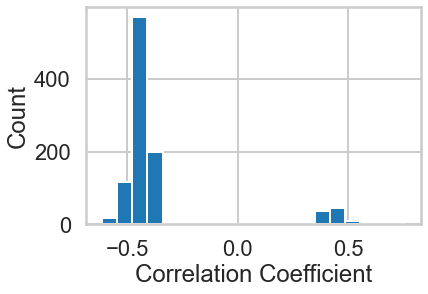

In [26]:
# Look at a histogram of the correlations between age and these top 1000 CpG sites
df_cpg_top1000.Correlation.hist(bins=20)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Count')
plt.show()

In [27]:
# Makle a new dataframe with the top 1000 CpGs sorted by age from the data, df_betas
new_cols = ['PATNO', 'Age'] + list(df_cpg_top1000.CpG)
df_betas_1000 = df_betas[new_cols]
df_betas_1000_sba = df_betas_1000.sort_values('Age').reset_index(drop=True)
df_betas_1000_sba = df_betas_1000_sba.iloc[1:, :].reset_index(drop=True)

In [28]:
df_betas_1000_sba.to_csv('../files/df_betas_1000_sba.csv')

In [39]:
df_betas_1000_sba = pd.read_csv('../files/df_betas_1000_sba.csv', index_col=0)
df_betas_1000_sba

,PATNO,Age,cg16867657,cg07323488,cg22454769,cg06784991,cg11436113,cg19283806,cg13552692,cg15736994,cg13823169,cg17740900,cg22156456,cg21141726,cg01974375,cg14620941,cg06639320,cg16054275,cg17268658,cg17403084,cg02402091,cg02513379,cg21323642,cg11218872,cg08097417,cg04875128,cg27099280,cg08262002,cg21531089,cg04640687,cg19784428,cg17554862,cg17015290,cg00067981,cg01528542,cg21990700,cg16454902,cg21572722,cg03708443,cg07082267,cg20249566,cg10677886,cg03473532,cg12857881,cg01649837,cg16152924,cg10358342,cg07080372,cg27037708,cg07553761,...,cg15755028,cg16060790,cg23763117,cg06156900,cg03162794,cg15383740,cg05081930,cg10573236,cg15480367,cg04090392,cg24293739,cg06934523,cg00170483,cg05293670,cg12773508,cg19458269,cg27589809,cg13938970,cg15017982,cg05494488,cg04931655,cg25816357,cg00985388,cg25887748,cg01420348,cg03520471,cg12113132,cg14834260,cg04765439,cg13179916,cg21571060,cg12551695,cg01399860,cg18622950,cg21159778,cg19433091,cg12762653,cg11331344,cg17260631,cg17990814,cg02378183,cg24434938,cg11212186,cg07346747,cg26952862,cg12172153,cg21735522,cg03495011,cg00876127,cg06195193
0,3074,31.160903,0.578927,0.378975,0.457985,0.047398,0.632738,0.352091,0.449920,0.694283,0.598616,0.221363,0.226464,0.268240,0.247975,0.411018,0.439071,0.457336,0.462365,0.314766,0.566498,0.314154,0.334919,0.838111,0.088211,0.045176,0.015948,0.549677,0.483787,0.224408,0.749287,0.250991,0.508203,0.446897,0.650999,0.361344,0.265566,0.360660,0.553290,0.484384,0.717076,0.270063,0.808778,0.526592,0.585479,0.315321,0.381759,0.198494,0.274411,0.341471,...,0.454526,0.758033,0.251611,0.538043,0.329494,0.700577,0.295965,0.036642,0.254986,0.164628,0.347918,0.347430,0.090603,0.087516,0.547467,0.220246,0.796455,0.341053,0.289910,0.107734,0.203640,0.923610,0.254756,0.912642,0.449093,0.506444,0.853285,0.559182,0.750266,0.690431,0.773313,0.918517,0.711754,0.758956,0.035248,0.265412,0.206678,0.323011,0.431298,0.632514,0.645956,0.076917,0.208775,0.592644,0.211319,0.150435,0.519017,0.569577,0.451857,0.222229
1,3011,31.901370,0.488026,0.293259,0.463545,0.049145,0.726317,0.364094,0.401152,0.689200,0.530503,0.364517,0.234148,0.324861,0.273877,0.374531,0.338134,0.493750,0.414104,0.298380,0.446016,0.328297,0.342171,0.872624,0.095952,0.100745,0.029406,0.654710,0.601623,0.323279,0.845464,0.261535,0.497459,0.501089,0.728971,0.285399,0.252470,0.380754,0.592001,0.424115,0.818410,0.350307,0.820865,0.578310,0.716764,0.350111,0.590313,0.187732,0.275202,0.325742,...,0.459647,0.872004,0.332013,0.518728,0.421791,0.796143,0.300028,0.043118,0.231129,0.165159,0.379526,0.358474,0.122279,0.100334,0.648851,0.206277,0.733007,0.420719,0.328466,0.119957,0.214700,0.914250,0.290981,0.833356,0.399915,0.467743,0.910113,0.462815,0.797504,0.691497,0.813776,0.889502,0.816124,0.856549,0.037262,0.314289,0.183749,0.268084,0.435869,0.739115,0.623907,0.068945,0.217249,0.602318,0.181790,0.222543,0.402175,0.470448,0.525204,0.203881
2,3619,32.191781,0.565370,0.370947,0.448252,0.084273,0.632496,0.228096,0.393248,0.669290,0.530521,0.323645,0.234084,0.294321,0.237031,0.387674,0.372612,0.496669,0.402739,0.319285,0.507779,0.333400,0.366444,0.836815,0.137023,0.207275,0.041526,0.628049,0.508198,0.227775,0.838281,0.265059,0.485081,0.442989,0.711690,0.253906,0.273574,0.354086,0.524787,0.444052,0.818540,0.323772,0.852722,0.567343,0.641723,0.328086,0.610304,0.169531,0.304208,0.454078,...,0.456604,0.854856,0.250625,0.509839,0.315792,0.801945,0.249726,0.053525,0.218639,0.167065,0.392425,0.372018,0.089969,0.061969,0.584836,0.245707,0.794908,0.313289,0.270846,0.089190,0.230328,0.919470,0.227421,0.913417,0.456999,0.509080,0.883062,0.496833,0.779655,0.681371,0.789017,0.930667,0.812901,0.765637,0.052240,0.228414,0.202547,0.325234,0.441241,0.676405,0.526451,0.077499,0.155888,0.606587,0.207760,0.195352,0.450023,0.515515,0.412759,0.223673
3,3355,32.331507,0.582600,0.368443,0.421757,0.082836,0.660496,0.413355,0.482633,0.739244,0.543889,0.358155,0.221292,0.293775,0.281048,0.395456,0.433126,0.459962,0.455290,0.356051,0.531810,0.346080,0

In [40]:
# Save list of 1000 columns
l = df_betas_1000_sba.columns[2:]
file_name = "../files/df_betas_1000_sba_columns"
open_file = open(file_name, "wb")
pickle.dump(l, open_file)
open_file.close()

In [41]:
# Run PCA on the 1000 cpg Columns
X = df_betas_1000_sba.iloc[:, 2:]
from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit(X)
X_t = pca.transform(X) # create transformed dataset

In [42]:
# Make a dataframe of the PCA results
df_X_t = pd.DataFrame(X_t, columns = ['PC1', 'PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
df_X_t.insert(0, 'Age', df_betas_1000_sba.Age)
df_X_t

,Age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,31.160903,1.410322,-0.149083,-0.003924,0.339824,-0.225056,-0.274833,0.500676,-0.434425,0.152855,0.146428
1,31.901370,2.643230,0.117338,0.363731,0.127928,-0.372562,0.292541,0.037271,0.208031,0.002331,-0.202920
2,32.191781,1.816160,0.018085,-0.098652,0.379347,-0.280754,0.065671,-0.157415,-0.253765,0.214904,0.167700
3,32.331507,2.563789,0.243374,-0.224600,0.117087,-0.029210,-0.296065,0.151504,0.045408,0.073020,-0.085447
4,39.780822,1.788937,-0.125074,-0.078516,0.428480,-0.016850,0.497352,0.250155,0.117919,0.030876,-0.225793
...,...,...,...,...,...,...,...,...,...,...,...
129,80.924231,-1.229664,-0.255744,0.068548,-0.076720,0.149926,-0.166304,-0.011240,-0.108850,-0.197165,-0.121673
130,81.263014,-1.144237,-0.401423,0.462364,-0.401424,0.296292,0.422696,0.061748,0.046570,0.269818,0.025015
131,81.890411,-2.067282,0.155542,-0.246954,-0.122068,-0.610744,-0.136240,0.537184,0.666191,-0.205022,-0.318933
132,82.712329,-1.383053,-0.230131,0.017263,-0.083438,0.177623,-0.327799,-0.075203,0.271697,0.007555,0.035119


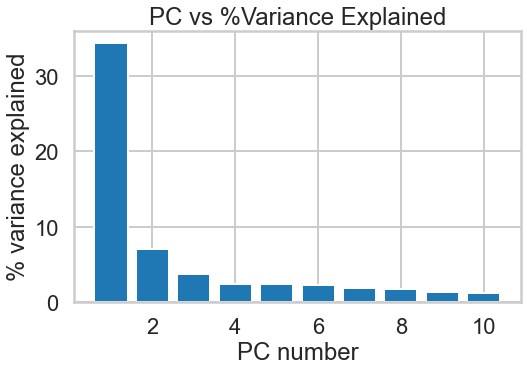

In [43]:
# Plotting % Variance explained by each PC
plt.figure(figsize=(8,5))
plt.bar(range(1,11, 1) , pca.explained_variance_ratio_*100)
plt.xlabel('PC number')
plt.ylabel('% variance explained')
plt.title('PC vs %Variance Explained')
plt.show()

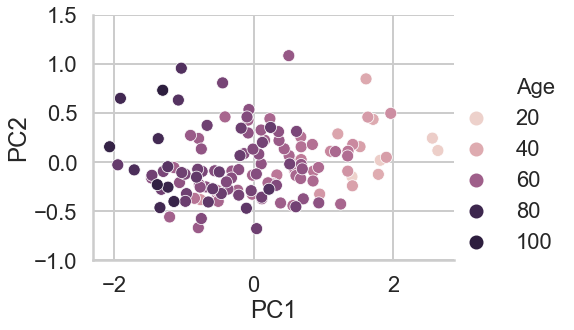

In [44]:
# Make a PCA plot 
sns.relplot(x= 'PC1', y= 'PC2', hue='Age', data =df_X_t, height=5, aspect= 1.3)
plt.ylim(-1, 1.5)
plt.show()

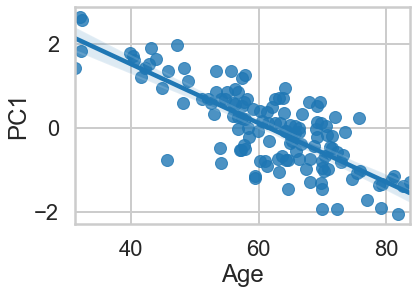

In [45]:
# Make a regression plot with Age and PC1
sns.regplot(x='Age', y='PC1', data=df_X_t)
plt.show()

In [46]:
# Calculate the correlation coefficient between age and PC1
df_X_t.Age.corr(df_X_t.PC1)

-0.7857567504860012

In [47]:
# Run a linear regression model , all 10 PCs on Age

import statsmodels.api as sm
X = df_X_t.iloc[:, 1:]
X_plus = sm.add_constant(X)
Y_plus = df_X_t.Age
model= sm.OLS(Y_plus, X_plus)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     69.11
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           1.22e-45
Time:                        18:34:40   Log-Likelihood:                -384.25
No. Observations:                 134   AIC:                             790.5
Df Residuals:                     123   BIC:                             822.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.5384      0.384    160.322      0.0